In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

def print_warn(*args):
    printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{' '.join(map(str, args))}</font></code>")

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.axisbelow'] = True
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/local_planning_ros2_foxy/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/local_planning_ros2_foxy/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_relative_translation_error_mean': 'relative_translation_error',
    'collisionless_localization_update_relative_rotation_error_mean': 'relative_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
    'localization_node': 'localization',
    'local_planner_node': 'local_planner',
    'global_planner_node': 'global_planner',
})
results_info['run_parameter_names'] = [s.replace('_node', '') for s in results_info['run_parameter_names']]
# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# only consider real localization
df = df[df.localization != 'localization_generator']

# only consider amcl_alpha_factor if 0.0, 0.5, 1.0, or 2.0
# df = df[df.amcl_alpha_factor == 1.0]
df = df[df.amcl_alpha_factor.isin([0.0, 0.5, 1.0, 2.0])].copy()

# turn odometry_error into beta..4
results_info['run_parameter_names'] += ['beta', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df['beta'] = df['beta_1']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['planner_cpu_utilization'] = df['planner_cpu_time'] / df['system_cpu_time']
df['controller_cpu_utilization'] = df['controller_cpu_time'] / df['system_cpu_time']
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
df['collisionless_failure_rate'] = (1 - df['success_rate']) & (1 - df['collision_rate'])
df['global_planner_failure_rate'] = (df.trajectory_length < 0.75) & (df.average_velocity < 0.001)
df['global_planner_success_rate'] = 1 - df['global_planner_failure_rate']

metrics += ['collisionless_failure_rate', 'global_planner_success_rate', 'global_planner_failure_rate', 'average_velocity']
metrics_and_versions += ['collisionless_failure_rate', 'global_planner_success_rate', 'global_planner_failure_rate', 'average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if False:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

In [6]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, output_metric_name=None, min_y=0.0, plot_all=True, scatter=True, extra_name="", size=[4, 4]):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization in df.localization.unique():
            for local_planner in df.local_planner.unique():
                
                ds = selected_df[
                    (selected_df.localization == localization) & 
                    (selected_df.local_planner == local_planner) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(ds[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(ds[input_metric.name])/max_scatter_points))
                        plt.scatter(ds[input_metric.name][::n], ds[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(ds[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        ds['x_range'] = pd.cut(ds[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        ds_g = ds.groupby('x_range')[output_metric.name].agg(['mean', 'count'])
                        ds_g = ds_g[ ds_g['count'] > min_bin_count ]
                        plt.plot(ds_g.index, ds_g['mean'], f'{local_planner_symbol[local_planner]}-', fillstyle='none', mfc=None, label=f'{local_planner}', linewidth=1, color=local_planner_color[local_planner])
                    else:
                        ds_g = ds.groupby(input_metric.name)[output_metric.name].agg(['mean', 'count'])
                        ds_g = ds_g[ ds_g['count'] > min_bin_count ]
                        plt.plot(ds_g.index, ds_g['mean'], f'{local_planner_symbol[local_planner]}-', fillstyle='none', mfc=None, label=f'{local_planner}', linewidth=1, color=local_planner_color[local_planner])
                    max_y = max(max_y, ds_g['mean'].max())
        
        if output_metric_name is None:
            output_metric_name = output_metric.name.replace('_', ' ')
        
        plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric_name)
        if max_y >= min_y:
            plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches(size)
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}{extra_name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


In [7]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def logistic_regression(d, input_metric, bin_width, output_metric, out_dir, size=[4, 4], min_bin_count=10, output_metric_name=None, ylim=[-0.05, 1.05], extra_name="", scatter=False):
    fig = plt.figure()
    for local_planner in df.local_planner.unique():
        ds = d[(d.local_planner == local_planner) & d[input_metric].notna() & d[output_metric].notna()].copy()
        
        if len(ds[input_metric]):
            X = ds[input_metric].values.reshape(-1, 1)
            y = ds[output_metric].values
            
            clf = LogisticRegression(C=1e5)
            clf.fit(X, y)
            X_pred = np.linspace(np.min(X), np.max(X), 100)
            y_pred = clf.predict_proba(X_pred.reshape(-1, 1))[:, 1]

#             lr = LogisticRegression()
#             pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
#             pipeline = Pipeline([('polynomial_features', pf), ('logistic_regression', lr)])
#             pipeline.fit(X, y)
#             pipeline.score(X, y)
#             X_pred = np.linspace(np.min(X), np.max(X), 100)
#             y_pred = pipeline.predict_proba(X_pred.reshape(-1, 1))[:, 1]

            if bin_width is None:
                ds['x_range'] = ds[input_metric]
            else:
                bins = np.arange(0., ds[input_metric].max() + bin_width, bin_width)
                ds['x_range'] = pd.cut(ds[input_metric], bins, labels=bins[:-1]).astype('float')
            
            ds_g = ds.groupby('x_range')[output_metric].agg(['mean', 'count'])
            ds_g = ds_g[ ds_g['count'] >= min_bin_count ]
#             plt.plot(ds_g.index, ds_g['mean'], f'{local_planner_symbol[local_planner]}', fillstyle='none', mfc=None, label=f'{local_planner} discrete', linewidth=1, color=local_planner_color[local_planner])
#             plt.plot(X_test, loss, '-', fillstyle='none', mfc=None, label=f'{local_planner} log. reg.', linewidth=1, color=local_planner_color[local_planner])

            if scatter:
                plt.plot(ds_g.index, ds_g['mean'], f'{local_planner_symbol[local_planner]}', fillstyle='none', mfc=None, linewidth=1, color=local_planner_color[local_planner])
            plt.plot(X_pred, y_pred, '-', fillstyle='none', mfc=None, linewidth=1, color=local_planner_color[local_planner])
            plt.plot([], [], f'{local_planner_symbol[local_planner]}-', fillstyle='none', mfc=None, label=f'{local_planner}', linewidth=1, color=local_planner_color[local_planner])
    
    if output_metric_name is None:
        output_metric_name = output_metric.replace('_', ' ')

    plt.legend()
    plt.grid()
    plt.xlabel(input_metric.replace('_', ' '))
    plt.ylabel(output_metric_name)
    plt.ylim(ylim)
    fig.set_size_inches(size)
    if not path.exists(out_dir):
        os.makedirs(out_dir)
#         fig.savefig(out_dir + f"/{output_metric}---{input_metric}{extra_name}--logistic-regression.pdf".replace('_', '-'), bbox_inches='tight')
    plt.show()


In [8]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def logistic_regression_add(fig, d, input_metric, bin_width, output_metric, min_bin_count=10, scatter=False, color=None, label=None):
    for local_planner in df.local_planner.unique():
        ds = d[(d.local_planner == local_planner) & d[input_metric].notna() & d[output_metric].notna()].copy()
        
        if len(ds[input_metric]):
            X = ds[input_metric].values.reshape(-1, 1)
            y = ds[output_metric].values
            
            clf = LogisticRegression(C=1e5)
            clf.fit(X, y)
            X_pred = np.linspace(np.min(X), np.max(X), 100)
            y_pred = clf.predict_proba(X_pred.reshape(-1, 1))[:, 1]

            if bin_width is None:
                ds['x_range'] = ds[input_metric]
            else:
                bins = np.arange(0., ds[input_metric].max() + bin_width, bin_width)
                ds['x_range'] = pd.cut(ds[input_metric], bins, labels=bins[:-1]).astype('float')
            
            ds_g = ds.groupby('x_range')[output_metric].agg(['mean', 'count'])
            ds_g = ds_g[ ds_g['count'] >= min_bin_count ]
#             plt.plot(ds_g.index, ds_g['mean'], f'{local_planner_symbol[local_planner]}', fillstyle='none', mfc=None, label=f'{local_planner} discrete', linewidth=1, color=local_planner_color[local_planner])
#             plt.plot(X_test, loss, '-', fillstyle='none', mfc=None, label=f'{local_planner} log. reg.', linewidth=1, color=local_planner_color[local_planner])

            if scatter:
                plt.plot(ds_g.index, ds_g['mean'], f'{local_planner_symbol[local_planner]}', fillstyle='none', mfc=None, linewidth=1, color=color)
            plt.plot(X_pred, y_pred, '-', fillstyle='none', mfc=None, linewidth=2, color=color)
            plt.plot([], [], f'{local_planner_symbol[local_planner]}-', fillstyle='none', mfc=None, label=label, linewidth=1, color=color)


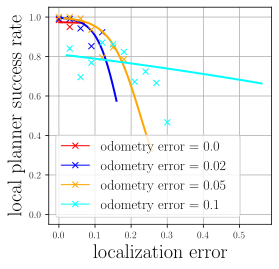

In [16]:
d = df[(df.global_planner_success_rate == 1) & (df.local_planner == 'teb') & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()

fig = plt.figure()

colors = ['red', 'blue', 'orange', 'cyan']
input_metric = 'absolute_translation_error'
output_metric = 'success_rate'
output_metric_name = f"local planner success rate"
extra_name = "--for-each-beta"

out_dir = "thesis_plots/local_planner_dependency"
ylim = [-0.05, 1.05]
size = [4, 4]
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


for i, beta in enumerate(sorted(d.beta.unique())):
    logistic_regression_add(
        fig,
        d=d[d.beta == beta],
        input_metric=input_metric,
        bin_width=0.03,
        min_bin_count=10,
        output_metric=output_metric,
        scatter=True,
        color=colors[i],
        label=f"odometry error = {beta}",
    )

plt.legend(fontsize=14)
plt.grid()
plt.xlabel("localization error", fontsize=20)
# plt.xlabel(input_metric.replace('_', ' '))
plt.ylabel(output_metric_name, fontsize=20)
plt.ylim(ylim)
fig.set_size_inches(size)
if not path.exists(out_dir):
    os.makedirs(out_dir)
fig.savefig(out_dir + f"/{output_metric}---{input_metric}{extra_name}--logistic-regression--with-datapoints.pdf".replace('_', '-'), bbox_inches='tight')
fig.savefig(out_dir + f"/{output_metric}---{input_metric}{extra_name}--logistic-regression--with-datapoints.png".replace('_', '-'), bbox_inches='tight')
plt.show()

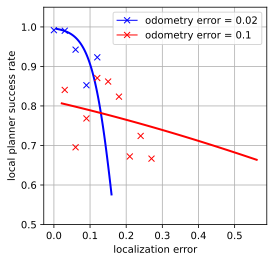

In [10]:
d = df[(df.global_planner_success_rate == 1) & (df.local_planner == 'teb') & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()

fig = plt.figure()

colors = ['blue', 'red', 'orange', 'cyan']
input_metric = 'absolute_translation_error'
output_metric = 'success_rate'
output_metric_name = f"local planner success rate"
extra_name = "--for-two-beta"

out_dir = "thesis_plots/local_planner_dependency"
# ylim = [-0.05, 1.05]
ylim = [0.5, 1.05]
size = [4, 4]

for i, beta in enumerate([0.02, 0.1]):
    logistic_regression_add(
        fig,
        d=d[d.beta == beta],
        input_metric=input_metric,
        bin_width=0.03,
        min_bin_count=10,
        output_metric=output_metric,
        scatter=True,
        color=colors[i],
        label=f"odometry error = {beta}",
    )

plt.legend()
plt.grid()
plt.xlabel("localization error")
# plt.xlabel(input_metric.replace('_', ' '))
plt.ylabel(output_metric_name)
plt.ylim(ylim)
fig.set_size_inches(size)
if not path.exists(out_dir):
    os.makedirs(out_dir)
fig.savefig(out_dir + f"/{output_metric}---{input_metric}{extra_name}--logistic-regression--with-datapoints.pdf".replace('_', '-'), bbox_inches='tight')
fig.savefig(out_dir + f"/{output_metric}---{input_metric}{extra_name}--logistic-regression--with-datapoints.png".replace('_', '-'), bbox_inches='tight')
plt.show()

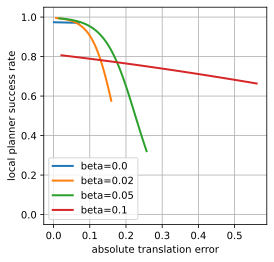

In [11]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


d = df[(df.global_planner_success_rate == 1) & (df.local_planner == 'teb') & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
input_metric = 'absolute_translation_error'
bin_width = 0.1
output_metric = 'success_rate'
output_metric_name = "local planner success rate"
extra_name = "--for-each-beta"

out_dir="thesis_plots/local_planner_dependency"
size=[4, 4]
min_bin_count=1
ylim=[-0.05, 1.05]
scatter = True

fig = plt.figure()
for local_planner in df.local_planner.unique():
    for beta in sorted(df.beta.unique()):
        ds = d[(d.local_planner == local_planner) & (d.beta == beta) & d[input_metric].notna() & d[output_metric].notna()].copy()

        if len(ds[input_metric]):
            X = ds[input_metric].values.reshape(-1, 1)
            y = ds[output_metric].values

            clf = LogisticRegression(C=1e5)
            clf.fit(X, y)
            X_pred = np.linspace(np.min(X), np.max(X), 100)
            y_pred = clf.predict_proba(X_pred.reshape(-1, 1))[:, 1]

            if bin_width is None:
                ds['x_range'] = ds[input_metric]
            else:
                bins = np.arange(0., ds[input_metric].max() + bin_width, bin_width)
                ds['x_range'] = pd.cut(ds[input_metric], bins, labels=bins[:-1]).astype('float')

            ds_g = ds.groupby('x_range')[output_metric].agg(['mean', 'count'])
            ds_g = ds_g[ ds_g['count'] >= min_bin_count ]
            plt.plot(X_pred, y_pred, '-', fillstyle='none', mfc=None, linewidth=2, label=f'beta={beta}')

if output_metric_name is None:
    output_metric_name = output_metric.replace('_', ' ')

plt.legend()
plt.grid()
plt.xlabel(input_metric.replace('_', ' '))
plt.ylabel(output_metric_name)
plt.ylim(ylim)
fig.set_size_inches(size)
if not path.exists(out_dir):
    os.makedirs(out_dir)
fig.savefig(out_dir + f"/{output_metric_name.replace(' ', '-')}---{input_metric}{extra_name}--logistic-regression.pdf".replace('_', '-'), bbox_inches='tight')
plt.show()
